##Description
 CNN for instrument classification based on the IRMAS dataset. We consider audio of 3s (sr= 44100) with polyphonic music and a single dominat instrument as label in the training. 

##Imports

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile
import librosa
import librosa.display
import sklearn

In [ ]:
#seed for random 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

##Paths and dataframe creation

In [ ]:
#path to data
cwd = os.getcwd()

#6705 audio file of 3s for 11 instruments
dataset_path = os.path.join(cwd, 'IRMAS-TrainingData')

In [ ]:
def path_from_file(filename, class_index, path, target_dict):
    return os.path.join(path, target_dict[class_index], filename)

In [ ]:
def path_list_from_frame(df):
    filenames = df['filename'].tolist()
    class_indexes = df['class_index'].tolist()
    audio_path = [path_from_file(filename, index, dataset_path, target_dict) for (filename, index) in zip(filenames, class_indexes)]
    
    return audio_path, class_indexes

In [ ]:
#compute the target dictionary and audio files names list
data = []

for (dirpath, dirnames, _) in os.walk(dataset_path):
    target_names = [x for x in dirnames if len(x) == 3]
    break

for (dirpath, dirnames, filenames) in os.walk(dataset_path):
    #create pandas frame and store audio files with relative class
    dirname = os.path.basename(dirpath)
    
    if len(dirname) == 3: 
        data.append(filenames)

#dict of targets
target_dict = dict(zip(range(0, 11), target_names))
print(target_dict)

In [ ]:
#dataframes
df = pd.DataFrame(columns=['filename', 'class_index'])

for class_index, el in enumerate(data):
    for filename in el:
        row = pd.Series({'filename': filename, 'class_index': class_index})
        df = df.append(row, ignore_index=True)

##Train-valid split

In [ ]:
#train-valid split
split = int(len(df)*0.9)
print('split point: {}'.format(split))

#shuffle
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

df_train = df[:split]
data_train_size = len(df_train)

df_valid = df[split:]
df_valid.reset_index(inplace=True, drop=True)
data_valid_size = len(df_valid)

print('train sample number: {}/{}'.format(data_train_size, len(df)))
print('valid sample number: {}/{}'.format(data_valid_size, len(df)))

split point: 6034
train sample number: 6034/6705
valid sample number: 671/6705


In [ ]:
#path list of audio files

#train
audio_path_train, target_train = path_list_from_frame(df_train)

#valid 
audio_path_valid, target_valid = path_list_from_frame(df_valid)

##Dataset 

In [ ]:
def load_audio(path, target):
    audio_binary = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    return audio, target

def compute_spec(audio):
    #downsamle
    audio = librosa.resample(audio.numpy(), sr, int(sr/2))
    #normalization
    audio = librosa.util.normalize(audio)
    #mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=int(sr/2), n_fft=2048, hop_length=256, win_length=512)
    #log of mel spectrogram magnitude
    db_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return db_spec

def audio_processing(audio, target):
    #convert to mono
    mono = tf.math.reduce_mean(audio, axis=1)
    #compute spectrogram
    mel_spec = tf.py_function(compute_spec, [mono], [tf.float32])
    #add channel dimension 
    mel_spec = tf.expand_dims(mel_spec[0], axis=-1)
   
    return mel_spec, target    

In [ ]:
#batch size
bs = 64

#sample rate 
sr = 44100

In [ ]:
#train dataset
dataset = tf.data.Dataset.from_tensor_slices((audio_path_train, target_train))
dataset = dataset.map(lambda path, target: load_audio(path, target), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(lambda audio, target: audio_processing(audio, target), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(bs)
dataset = dataset.repeat()
train_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#valid dataset
dataset = tf.data.Dataset.from_tensor_slices((audio_path_valid, target_valid))
dataset = dataset.map(lambda path, target: load_audio(path, target), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(lambda audio, target: audio_processing(audio, target), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(bs)
dataset = dataset.repeat()
valid_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##Dataset visualization

In [ ]:
it = iter(train_dataset)

input shape: (128, 259, 1)


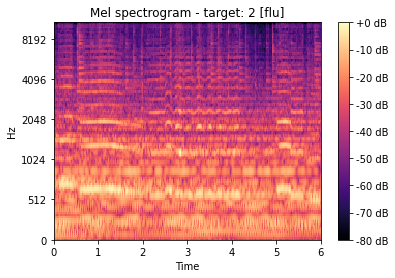

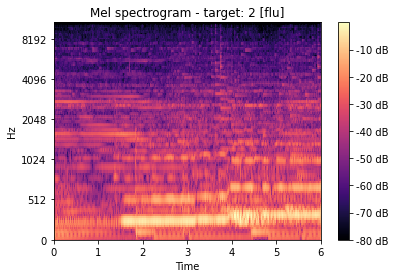

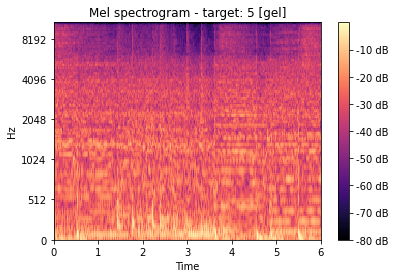

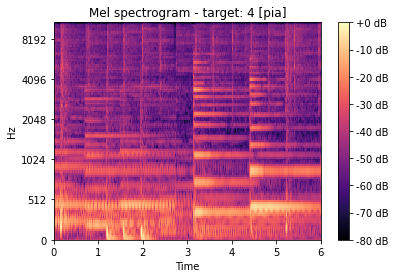

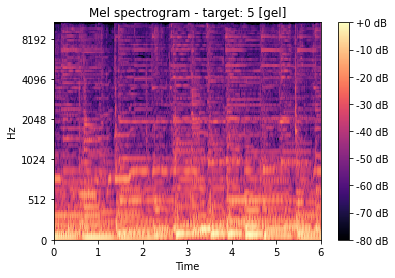

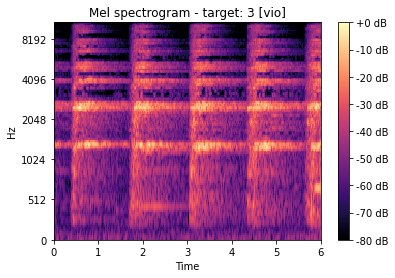

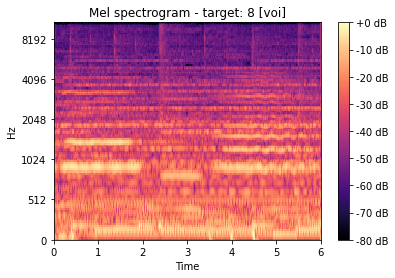

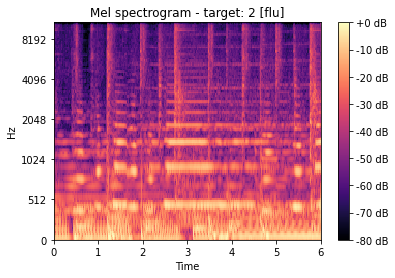

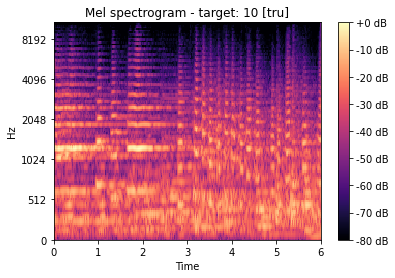

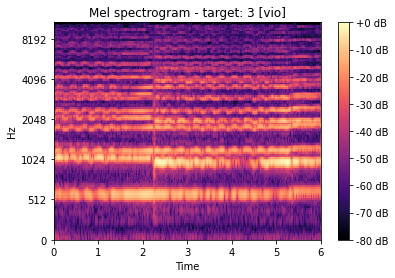

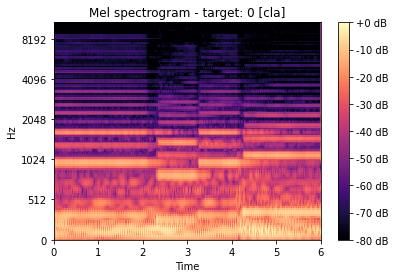

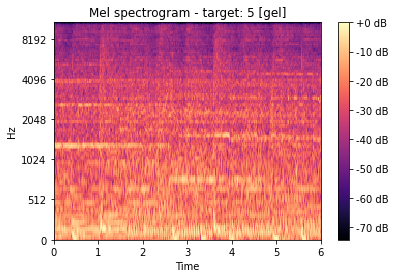

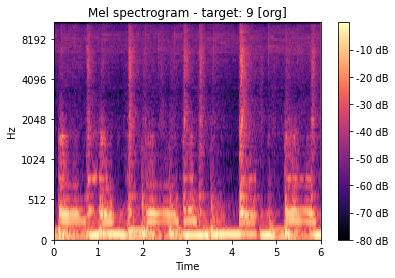

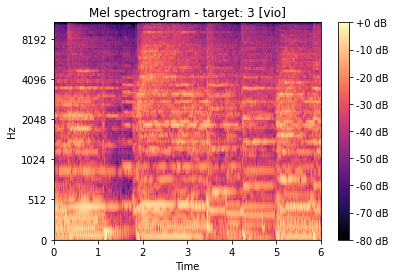

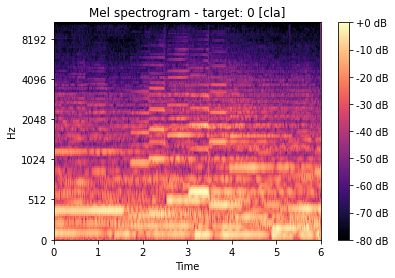

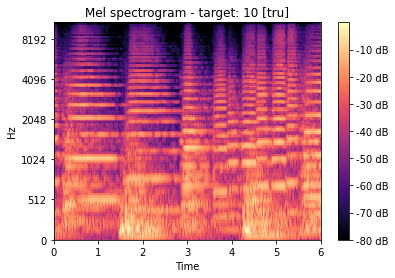

In [ ]:
#batch visualization
batch, targets = next(it)
print('input shape: {}'.format(batch[0].shape))

for el, t in zip(batch, targets):
    cur_el = el.numpy()[:, :, 0]

    #print the mel spectrogram
    fig, ax = plt.subplots()
    img = librosa.display.specshow(cur_el, x_axis='time', y_axis='mel', ax=ax)
    ax.set(title='Mel spectrogram - target: {} [{}]'.format(t, target_dict[int(t.numpy())]))
    fig.colorbar(img, ax=ax, format="%+2.f dB");

##Model

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=(128,130,1)))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3,3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.2, seed=SEED))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3,3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.2, seed=SEED))

model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3,3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.2, seed=SEED))

model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.2, seed=SEED))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=1024, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=SEED)))#, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.5, seed=SEED))
model.add(tf.keras.layers.Dense(units=11, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 130, 32)      320       
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 130, 32)      128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 130, 32)      9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 130, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 43, 44, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 43, 44, 32)        128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 43, 44, 32)       

##Training

In [ ]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# learning rate
lr = 1e-3

#optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#epochs 
epochs = 25

#class weights (None means uniform class weights)
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                                np.unique(target_train),
                                                                target_train)

class_weights_dict = {i: w for w, i in zip(class_weights, range(0, len(class_weights)))}
# -------------------

# Validation metrics
# ------------------

metrics = ['sparse_categorical_accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
def scheduler(epoch, lr):
   if epoch < 5:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

In [ ]:
callbacks = []

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)

# ---------------------------------
# Custom callbacks
#callbacks.append(CustomCallback())

#lr decay
callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1))

In [ ]:
#train
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=epochs,
                    steps_per_epoch=int(data_train_size/bs),
                    validation_steps=int(data_valid_size/bs),
                    class_weight = class_weights_dict,
                    callbacks=callbacks)

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
94/94 [==============================] - 1049s 11s/step - loss: 2.9286 - sparse_categorical_accuracy: 0.2052 - val_loss: 8.8367 - val_sparse_categorical_accuracy: 0.1344
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
94/94 [==============================] - 1024s 11s/step - loss: 2.1575 - sparse_categorical_accuracy: 0.3739 - val_loss: 2.3213 - val_sparse_categorical_accuracy: 0.4016
Epoch 3/25

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
94/94 [==============================] - 1047s 11s/step - loss: 1.7118 - sparse_categorical_accuracy: 0.4840 - val_loss: 1.9662 - val_sparse_categorical_accuracy: 0.4734
Epoch 4/25

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
94/94 [==============================] - 1026s 11s/step - loss: 1.4156 - sparse_categorical_accuracy: 0.56

KeyboardInterrupt: ignored

<function matplotlib.pyplot.show>

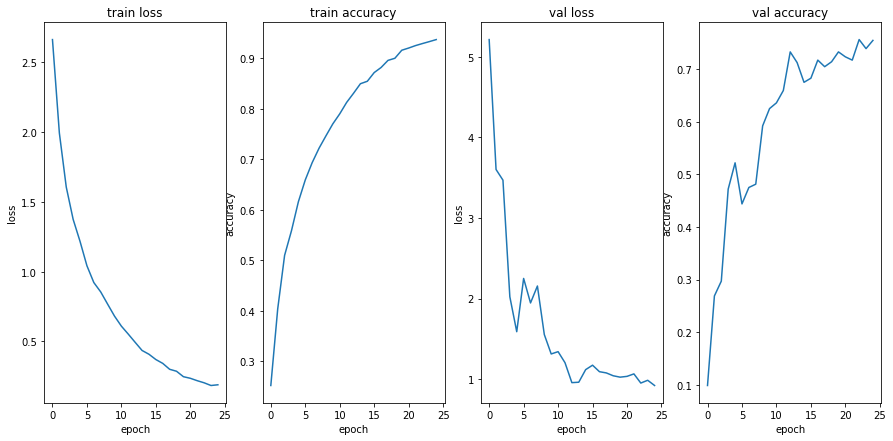

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,4,1)
plt.plot(model.history.history['loss'])
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

plt.subplot(1,4,2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show

plt.subplot(1,4,3)
plt.plot(history.history['val_loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show

plt.subplot(1,4,4)
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show

##Testing on some real songs

In [ ]:
model.load_weights('/content/gdrive/MyDrive/deep learning /instrument_classifier/model.h5')

In [ ]:
def load_test_audio(audio_path, frame_length, hop_length):
  predictions = []

  #use stream to create an iterator
  audio_it = librosa.stream(audio_path, 1, frame_length, hop_length=hop_length, mono=True)

  for block in audio_it:
    block_spec = compute_spec_test(block)

    #add batch dimension and channel dimension
    block_spec = np.expand_dims(block_spec, axis=-1)
    block_spec = np.expand_dims(block_spec, axis=0)
    predictions.append(model.predict(block_spec)[0])

  return predictions

In [ ]:
def compute_spec_test(audio):
    #downsamle
    audio = librosa.resample(audio, sr, int(sr/2))
    #normalization
    audio = librosa.util.normalize(audio)
    #mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=int(sr/2), n_fft=2048, hop_length=512, win_length=1024)
    #log of mel spectrogram magnitude
    db_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return db_spec

In [ ]:
#load a sample audio file
audio_path = '/content/We Make Our Own Holidays.wav'

#frame_length
audio_length = 6*sr

predictions = load_test_audio(audio_path, audio_length, hop_length=int(audio_length/4))

#compute global mean
mean_global = np.mean(np.array(predictions), axis=0)

#compute global predictions
global_predictions = np.argpartition(mean_global,range(mean_global.shape[0]))[-3:][::-1]
print('global_predictions: {}'.format([target_dict[el] for el in global_predictions]))
#print(mean_global)

#compute predictions at each frame
frame_predictions = np.argmax(predictions, axis=1)
print('frame_predictions: {}'.format([target_dict[el] for el in frame_predictions]))

global_predictions: ['gac', 'sax', 'gel']
frame_predictions: ['sax', 'gac', 'gel', 'gac', 'sax', 'sax', 'sax', 'gac', 'gel', 'sax', 'sax', 'sax', 'sax', 'sax', 'gac', 'gac', 'gac']


In [ ]:
print(target_dict)

{0: 'org', 1: 'cel', 2: 'cla', 3: 'voi', 4: 'gel', 5: 'flu', 6: 'gac', 7: 'tru', 8: 'vio', 9: 'sax', 10: 'pia'}
